# Module 10 Part 2: Introduction to Neural Networks

This module consists of 2 parts:

- **Part 1** - Focuses on the fundamentals (including a custom implementation of a feedforward neural network from scratch using NumPy)

- **Part 2** - Focuses on using packages like TensorFlow and Keras to rapidly develop and train deep neural network models

Each part is provided in a separate notebook file. It is recommended that you follow the order of the notebooks.

In the last section, we built a custom neural network model from scratch using NumPy, which was a lot of hard work. Fortunately, we can leverage the power of TensorFlow and Keras to build these models in a much easier fashion. 

We will build a model using Keras, a high level API that is built on top of TensorFlow which can greatly simplify the model development and testing process.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<br>
<div class="toc">
<ul class="toc-item">
<li><span><a href="#Module-10-Part-2:-Introduction-to-Neural-Networks" data-toc-modified-id="Module-10-Part-2:-Introduction-to-Neural-Networks">Module 10 Part 2: Introduction to Neural Networks</a></span>
</li>
<li><span><a href="#Table-of-Contents" data-toc-modified-id="Table-of-Contents">Table of Contents</a></span>
</li>
<li><span><a href="#Neural-Nets-with-Keras" data-toc-modified-id="Neural-Nets-with-Keras">Neural Nets with Keras</a></span>
<ul class="toc-item">
<li><span><a href="#Load-the-Dataset" data-toc-modified-id="Load-the-Dataset">Load the Dataset</a></span>
</li>
<li><span><a href="#Keras" data-toc-modified-id="Keras">Keras</a></span>
</li>
<li><span><a href="#Sequential-Models" data-toc-modified-id="Sequential-Models">Sequential Models</a></span>
</li>
<li><span><a href="#Functional-API" data-toc-modified-id="Functional-API">Functional API</a></span>
</li>
<li><span><a href="#Compile-and-Train" data-toc-modified-id="Compile-and-Train">Compile and Train</a></span>
</li>
<li><span><a href="#Evaluate-and-Predict" data-toc-modified-id="Evaluate-and-Predict">Evaluate and Predict</a></span>
</li>
<li><span><a href="#Saving-and-Restoring" data-toc-modified-id="Saving-and-Restoring">Saving and Restoring</a></span>
</li>
</ul>
</li>
<li><span><a href="#Basic-Fine-Tuning-of-Neural-Networks" data-toc-modified-id="Basic-Fine-Tuning-of-Neural-Networks">Basic Fine-Tuning of Neural Networks</a></span>
<ul class="toc-item">
<li><span><a href="#Choosing-the-Number-of-Hidden-Layers" data-toc-modified-id="Choosing-the-Number-of-Hidden-Layers">Choosing the Number of Hidden Layers</a></span>
</li>
<li><span><a href="#Choosing-the-Number-of-Neurons" data-toc-modified-id="Choosing-the-Number-of-Neurons">Choosing the Number of Neurons</a></span>
</li>
</ul>
</li>
<li><span><a href="#References" data-toc-modified-id="References">References</a></span>
</li>
</ul>
</div>

# Neural Nets with Keras

## Load the Dataset

Before we dig into model development, we will load our dataset. We will be working with the **Forest CoverType** dataset, available through sklearn's `datasets` API. We have printed the description below. However, for our purposes, all you really need to know is that it is a multi-class problem with 7 classes and 54 features. We will load, normalize, and split the data into training and test sets below.

In [1]:
from sklearn import datasets
data = datasets.fetch_covtype()
print(data['DESCR'])

.. _covtype_dataset:

Forest covertypes
-----------------

The samples in this dataset correspond to 30×30m patches of forest in the US,
collected for the task of predicting each patch's cover type,
i.e. the dominant species of tree.
There are seven covertypes, making this a multiclass classification problem.
Each sample has 54 features, described on the
`dataset's homepage <https://archive.ics.uci.edu/ml/datasets/Covertype>`__.
Some of the features are boolean indicators,
while others are discrete or continuous measurements.

**Data Set Characteristics:**

    =================   ============
    Classes                        7
    Samples total             581012
    Dimensionality                54
    Features                     int
    =================   ============

:func:`sklearn.datasets.fetch_covtype` will load the covertype dataset;
it returns a dictionary-like 'Bunch' object
with the feature matrix in the ``data`` member
and the target values in ``target``. If optional a

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from datetime import datetime
from time import time
import numpy as np
import os

X_raw = data['data']
X_raw_scaled = StandardScaler().fit_transform(X_raw)
y_raw = data['target']
y_raw_oh = OneHotEncoder(categories='auto', sparse=False).fit_transform(y_raw.reshape(-1,1))

X_train, X_test, y_train, y_test = train_test_split(X_raw_scaled, y_raw_oh, shuffle=True)
n_classes = len(np.unique(y_raw))
n_inputs = X_train.shape[1]

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("n_inputs:", n_inputs)
print("n_classes:", n_classes)

X_train shape: (435759, 54)
X_test shape: (145253, 54)
y_train shape: (435759, 7)
y_test shape: (145253, 7)
n_inputs: 54
n_classes: 7


## Keras 

**Keras** is a high-level API used for quickly developing and testing neural network models, and can leverage lower level graph-based architectures on the backend (e.g. TensorFlow or Theano). To clarify, it is important to understand that most deep learning frameworks operate at 2 levels of abstraction:

1. **Lower Level:** This is where frameworks like Tensorflow, MXNet, Theano, and PyTorch sit. This is the level where mathematical operations like matrix multiplication and convolutional operations are implemented.<br><br>

2. **Higher Level:** This is where frameworks like Keras sit. At this level, the lower level functions are used to implement neural network abstractions such as layers and models. Generally, at this level other helpful APIs like model saving and model training are also implemented.

As noted, Keras can be used with multiple backends. In fact, if you install Keras and import it as is, you should automatically get a message stating that it is running Keras "Using TensorFlow backend" (this will only display the first time you import the Keras module). If you plan to actively maintain framework-agnostic code (e.g. if you want to run your models using Theano or PyTorch as well), using Keras-only code is your only choice.

That said, the implementation we will be working with is called `tf.keras`, which is an implementation of Keras **implemented exclusively with/for TensorFlow**. Although `tf.keras` and `Keras` have separate code bases, they are tightly coupled. With updated documentation and programmer guides, `tf.keras` is clearly the high level API to look for when building neural networks with TensorFlow. As a rule of thumb, you should try not to mix base `tf` code with `tf.keras` code. Most things in TensorFlow will have a corresponding `tf.keras` implementation (though the level of customization may be lower). So, unless you need something very custom and specific, try to stick with the `tf.keras` code

**NOTE**: When we refer to Keras henceforth, we will be referring strictly to `tf.keras` (though much of the implementation would look the same either way).

With Keras there are two main methods for building models:

1. **Sequential API:** Which allows you to stack layers in a linear fashion, one after the other. This doesn't allow for flexible model architectures, but is great for building simple models very quickly.<br><br>

2. **Functional API**: Which allows for more flexibility in your model architecture (multiple inputs/outputs, reusing parameters, etc). This requires a bit more finesse, but can be very useful for advanced and complex architectures.

We will go through both of these strategies now.

In [3]:
# Loading tf.keras (TensorFlow specific implementation of Keras) 
import tensorflow as tf
from tensorflow import keras 
import tensorflow.keras.backend as K
print(tf.keras.__version__)

2.4.0


## Sequential Models

With the `Sequential` method, you assemble your model one layer at a time. To build a simple, fully-connected network we would do the following:

In [4]:
# Clear the session (similar to tf.reset_default_graph)
K.clear_session()

# Initialize model
model = keras.Sequential()
# Adds a densely-connected layer with 32 units to the model. Specify the input_shape for the first layer!
model.add(keras.layers.Dense(units=32, activation='relu', input_shape=(54,)))
# Add another:
model.add(keras.layers.Dense(units=32, activation='relu'))
# Add a softmax layer with 10 output units:
model.add(keras.layers.Dense(units=7, activation='softmax'))

# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                1760      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 231       
Total params: 3,047
Trainable params: 3,047
Non-trainable params: 0
_________________________________________________________________


There are a few main components to explain here:

- `tf.keras.Sequential()`: This initializes our model. You can think of this as setting up a blank graph, to which we will simply add layers one at a time.


- `model.add()`: Once we have initialized our model, we can simply add layers to it with the `.add` method, through which we pass the layer type we want to add.


- `keras.layers.Dense()`: We use this function to tell `model.add()` that we'd like to add a fully-connected dense layer to our model. In this function we specify the number of neurons (`inputs`), and the activation function. Note that the first time we add a layer, we must specify the `input_shape` so the model knows what to expect for our `X` values.


- `model.summary()`: This method gives us a quick and simple summary of our model layers, with the output layer type, output shape, and number of parameters in each layer.

We use `tf.keras.layers.Dense` to sequentially add layers to the model. `tf.keras.layers.Dense` is a "tensorflow-keras" layer while `tf.layers.Dense` is a TensorFlow "native layer". However, the arguments for both are almost identical (again, we won't go into the details of most of these arguments for now, as you will only need the `units`, `activation`, `use_bias`, and `kernel_initializer` for our purposes).


**`tf.layers.Dense` arguments:**
- `(['units', 'activation=None', 'use_bias=True', 'kernel_initializer=None', 'bias_initializer=<tensorflow.python.ops.init_ops.Zeros object at 0x0000014437E068D0>', 'kernel_regularizer=None', 'bias_regularizer=None', 'activity_regularizer=None', 'kernel_constraint=None', 'bias_constraint=None', 'trainable=True', 'name=None', '**kwargs'])`

**`tf.keras.layers.Dense` arguments:**
- `(['units', 'activation=None', 'use_bias=True', "kernel_initializer='glorot_uniform'", "bias_initializer='zeros'", 'kernel_regularizer=None', 'bias_regularizer=None', 'activity_regularizer=None', 'kernel_constraint=None', 'bias_constraint=None', '**kwargs'])`
)

The `tf.layers` module is Tensorflow's attempt at creating a Keras-like API (as mentioned, Keras can be run with various neural net frameworks other than TensorFlow), whereas `tf.keras.layers` is simply a compatibility wrapper that leverages the underlying TensorFlow architecture. In fact, most of the `tf.keras.layers` implementation refers back to `tf.layers`, for example `tf.keras.layers.Dense` inherits the [core TensorFlow implementation](https://github.com/tensorflow/tensorflow/blob/23c218785eac5bfe737eec4f8081fd0ef8e0684d/tensorflow/python/keras/_impl/keras/layers/core.py#L728).


**Note that you cannot use a native TensorFlow layer directly within a Keras model, as it will be missing certain attributes required by the Keras API &mdash; give it a try above, and you will get some funky errors!** However, it is possible to use a TensorFlow native layer if it is wrapped within a `tf.keras` [Lambda layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Lambda). It is recommended that you stick to one or the other as mixing them can create some unexpected compatibility issues.

We can also build our model by passing in a list of layers into the actual `tf.keras.Sequential` class. From here we can continue to add layers as we please, just as we did above. We have also added some code to explore the "model configuration" using the `.get_config()` attribute.

In [5]:
K.clear_session()
model = keras.Sequential([
        # Adds a densely-connected layer with 64 units to the model:
        keras.layers.Dense(32, activation='relu', input_shape=(54,)),
        # Add another:
        keras.layers.Dense(32, activation='relu')])
# Add a final softmax layer
model.add(keras.layers.Dense(7, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                1760      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 231       
Total params: 3,047
Trainable params: 3,047
Non-trainable params: 0
_________________________________________________________________


In [6]:
# Check out model config
for key, val in model.get_config().items():
    print(key)
    print(val, "\n")

name
sequential 

layers
[{'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 54), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'dense_input'}}, {'class_name': 'Dense', 'config': {'name': 'dense', 'trainable': True, 'batch_input_shape': (None, 54), 'dtype': 'float32', 'units': 32, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}}, {'class_name': 'Dense', 'config': {'name': 'dense_1', 'trainable': True, 'dtype': 'float32', 'units': 32, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': Non

## Functional API

The `tf.keras.Sequential` model is a simple stack of layers that cannot represent arbitrary models. However, we often want to construct models with more complex topologies, including:
 
- Multi-input models
- Multi-output models
- Models with shared layers (the same layer called several times)
- Models with non-sequential data flows (e.g. residual connections)

For these kinds of models, we use the [Keras functional API](https://keras.io/getting-started/functional-api-guide/). The development process is slightly different, but most of the functionality will remain the same. Let's reconstruct our simple classification model using the functional API.

In [7]:
K.clear_session()
# Declare input layer
X = keras.Input(shape=(54,), name='X_Inputs')  # Returns a placeholder tensor

# Feed layers into one another sequentially
L1 = keras.layers.Dense(32, activation='relu', kernel_initializer='random_uniform', name='Layer_1')(inputs=X)
L2 = keras.layers.Dense(32, activation='relu', kernel_initializer='random_uniform', name='Layer_2')(inputs=L1)
y_proba = keras.layers.Dense(7, activation='softmax', kernel_initializer='random_uniform', name='Y_Outputs')(inputs=L2)

# Feed X and y_proba into keras.Model class
model = tf.keras.Model(inputs=[X], outputs=[y_proba], name='my_functional_model')

model.summary()

Model: "my_functional_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X_Inputs (InputLayer)        [(None, 54)]              0         
_________________________________________________________________
Layer_1 (Dense)              (None, 32)                1760      
_________________________________________________________________
Layer_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
Y_Outputs (Dense)            (None, 7)                 231       
Total params: 3,047
Trainable params: 3,047
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Check out model config
for key, val in model.get_config().items():
    print(key)
    print(val, "\n")

name
my_functional_model 

layers
[{'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 54), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'X_Inputs'}, 'name': 'X_Inputs', 'inbound_nodes': []}, {'class_name': 'Dense', 'config': {'name': 'Layer_1', 'trainable': True, 'dtype': 'float32', 'units': 32, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'RandomUniform', 'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'Layer_1', 'inbound_nodes': [[['X_Inputs', 0, 0, {}]]]}, {'class_name': 'Dense', 'config': {'name': 'Layer_2', 'trainable': True, 'dtype': 'float32', 'units': 32, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'RandomUniform', 'config': {'minval': -0.05, 'maxval': 0.05, 'seed': No

There are a couple of major differences to take note of here:

1. Instead of passing in an `input_shape` argument into our first layer as we did with the Sequential model, we instead must define a `tf.keras.Input` class, which is then then fed into the `tf.keras.Model` class. Setting up our model this way allows us to specify multiple inputs and outputs, and gives us more flexibility when designing our model structures. Note that we feed in `y_proba` (the last layer of our model) to the `outputs` argument of `tf.keras.Model`.<br><br>

2. Just as we did with the `tf.layers` model in the TensorFlow implementation section, when using the functional API we have to sequentially pass the layers into one another. In this way, the functional API combines the flexibility of TensorFlow, with the ease of development of the Keras high level API. 

Once we have defined our layers and passed the input and output tensors (or rather, the variables that reference the tensors) into a `tf.keras.Model` class, everything else stays the same as with the Sequential API. We can call the usual methods `.fit`, `.evaluate`, and `.predict` (as we will discuss shortly) on all of the above `tf.keras` models.

**NOTE**: The `.get_config()` output is slightly different for functional API models. This is because the flexible architecture requires a slightly more complex configuration. You are encouraged to compare the config output above with that of the previous model.

## Compile and Train

After the model is constructed, we can configure its learning process by calling the `tf.keras.Model.compile` method. The compile method takes three important arguments:

1. **`optimizer`**: This object specifies the training procedure. You can pass it optimizer instances from the `tf.keras.optimizers` module, such as `tf.keras.optimizers.SGD` (Stochastic Gradient Descent), `tf.keras.optimizers.RMSprop`, or `tf.keras.optimizers.Adam`. Note that you must call these optimizers first, passing in the required parameters (see below for an example).<br><br>

2. **`loss`**: The function to minimize during optimization. Common choices include mean square error (MSE), `categorical_crossentropy`, and `binary_crossentropy`. Loss functions are specified by name (string) or by passing a callable object from the `tf.keras.losses` module.<br><br>

3. **`metrics`**: Used to monitor training. These are string names or callables from the `tf.keras.metrics` module.

The `compile` method essentially sets up our model so that it is ready for training. In the next cell, we create a model and compile it with a gradient descent optimizer using categorical cross-entropy as the loss function.

In [9]:
K.clear_session()
model = keras.Sequential([keras.layers.Dense(32, activation='relu', input_shape=(54,)),
                             keras.layers.Dense(32, activation='relu'),
                             keras.layers.Dense(7, activation='softmax')]) # 7 classes 

# Compile the model using Gradient Descent
optimizer = tf.keras.optimizers.SGD(lr=0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

print(model.inputs)
print(model.outputs)
model.summary()

[<KerasTensor: shape=(None, 54) dtype=float32 (created by layer 'dense_input')>]
[<KerasTensor: shape=(None, 7) dtype=float32 (created by layer 'dense_2')>]
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                1760      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 231       
Total params: 3,047
Trainable params: 3,047
Non-trainable params: 0
_________________________________________________________________


Training (or fitting) a model with Keras is extremely simple, and very much resembles the simple `.fit` methodology used by Scikit-learn. To fit a Keras model, all you have to do is call `tf.keras.Model.fit`, which takes in three important arguments:

1. **`epochs`**: An epoch is one iteration over the entire input dataset.<br><br>

2. **`batch_size`**: When passed NumPy data, the model slices the data into smaller batches and iterates over these batches during training. This integer specifies the size of each batch. Be aware that the last batch may be smaller if the total number of samples is not divisible by the batch size.<br><br>

3. **`validation_data`**: When prototyping a model, you want to be able to easily monitor its performance on some validation data. Passing this argument &mdash; a tuple of inputs and labels &mdash; allows the model to display the loss and metrics in inference mode for the passed data, at the end of each epoch.

Let's train with a batch size of 3,200 for 30 epochs.

**NOTE**: Keras produces a progress bar to track the model training. You can change how much training information you want to see with the `verbose` argument.

In [11]:
K.clear_session()
model = keras.Sequential([keras.layers.Dense(32, activation='relu', input_shape=(54,), kernel_initializer='random_uniform'),
                             keras.layers.Dense(32, activation='relu', kernel_initializer='random_uniform'),
                             keras.layers.Dense(7, activation='softmax',kernel_initializer='random_uniform')])
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Fit the model
model.fit(X_train, y_train, epochs=50, batch_size=3200, validation_data=(X_test, y_test), verbose=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                1760      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 231       
Total params: 3,047
Trainable params: 3,047
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
137/137 [==============================] - 1s 5ms/step - loss: 1.8711 - accuracy: 0.4697 - val_loss: 1.6794 - val_accuracy: 0.4869
Epoch 2/50
137/137 [==============================] - 0s 3ms/step - loss: 1.6307 - accuracy: 0.4865 - val_loss: 1.5087 - val_accuracy: 0.4869
Epoch 3/50
137/137 [==============================] - 0s 3ms/step - loss: 1.4760 - accuracy: 0.4887 

There's one last thing to mention here. You may have noticed that at the end of training Keras returned a `keras.callbacks.History` object. This essentially stores results from our training process. It can be accessed as follows:

In [12]:
results  = model.history.history
results.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

As you can see, the model automatically stores the loss and accuracy values for both the training and test sets at every epoch. We can also ask Keras to store more metrics when we compile the model with the `metrics` argument. Let's plot the results below.

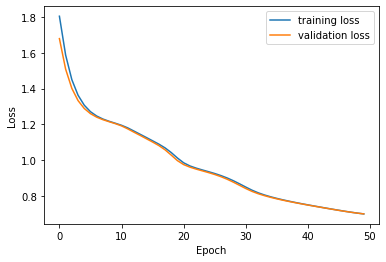

In [13]:
# Plot loss values
plt.plot(results['loss'], label='training loss')
plt.plot(results['val_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


**NOTE:** If you don't see the training and validation loss lines, its likely because they are overlapping. Try running the model again to see if you get a slightly different result.

## Evaluate and Predict

Evaluating your models and making predictions is also simple using Keras. Again, all you have to do is call the `.evaluate` and `.predict` methods on your model, and pass in the testing data you would like to use.

- `tf.keras.Model.evaluate` returns a list of two values: `[loss, accuracy_score]` (this may change based on what scoring metric you are using for your model).


- `tf.keras.Model.predict` returns a NumPy array, the shape of which is determined by the structure of the model and the loss function you specified. For instance, in our model, `.predict` will return the probability scores for each class in the shape of `(n_observations, n_classes)`.

Instead of having to save the model, reload it, and restore the weights, Keras stores the trained model variables and makes them readily accessible for you. This makes testing and making predictions much easier.

In [14]:
model.evaluate(X_test, y_test, batch_size=32)

4540/4540 [==============================] - 2s 513us/step - loss: 0.6990 - accuracy: 0.7103


[0.699042558670044, 0.7102985978126526]

In [15]:
result = model.predict(X_test, batch_size=32)
print(result.shape)
result[0:5]

(145253, 7)


array([[6.9662708e-01, 2.6919577e-01, 5.4339424e-04, 4.0215359e-04,
        5.5236751e-03, 1.0010714e-03, 2.6706874e-02],
       [5.4932821e-01, 4.3938294e-01, 8.1884791e-05, 6.6983004e-05,
        2.1623524e-03, 2.0401221e-04, 8.7736277e-03],
       [4.5108137e-01, 5.2948439e-01, 3.1530851e-04, 2.2538479e-04,
        4.4310545e-03, 6.3967938e-04, 1.3822753e-02],
       [6.5991992e-01, 3.1385604e-01, 3.8822502e-04, 2.8312631e-04,
        4.7426247e-03, 7.7033456e-04, 2.0039763e-02],
       [7.4131697e-01, 2.4970689e-01, 2.5262527e-05, 2.4109075e-05,
        1.1111184e-03, 7.3573734e-05, 7.7420869e-03]], dtype=float32)

## Saving and Restoring

With `tf.keras`, we can save just the weights of our model, or the configuration, or both! By default, this saves the model's weights in the
[TensorFlow checkpoint](https://www.tensorflow.org/guide/checkpoints) file format. Weights can also be saved to the Keras HDF5 format (the default for the multi-backend
implementation of Keras):

In [16]:
# Save weights to a TensorFlow Checkpoint file
model.save_weights('./weights/my_model')

# Restore the model's state,
# this requires a model with the same architecture.
model.load_weights('./weights/my_model')

You can also save a model's configuration by serializing the model architecture without any weights. A saved configuration can recreate and initialize the same model, even without the code that defined the original model. Keras supports JSON and YAML serialization formats.

In [17]:
import json
import pprint

# Serialize a model to JSON format
json_string = model.to_json()
json_string

pprint.pprint(json.loads(json_string))

{'backend': 'tensorflow',
 'class_name': 'Sequential',
 'config': {'layers': [{'class_name': 'InputLayer',
                        'config': {'batch_input_shape': [None, 54],
                                   'dtype': 'float32',
                                   'name': 'dense_input',
                                   'ragged': False,
                                   'sparse': False}},
                       {'class_name': 'Dense',
                        'config': {'activation': 'relu',
                                   'activity_regularizer': None,
                                   'batch_input_shape': [None, 54],
                                   'bias_constraint': None,
                                   'bias_initializer': {'class_name': 'Zeros',
                                                        'config': {}},
                                   'bias_regularizer': None,
                                   'dtype': 'float32',
                                   'kernel_

In [18]:
# Reload the model from json
fresh_model = tf.keras.models.model_from_json(json_string)
fresh_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                1760      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 231       
Total params: 3,047
Trainable params: 3,047
Non-trainable params: 0
_________________________________________________________________


# Basic Fine-Tuning of Neural Networks

Alright, now that we can quickly whip up a fancy neural network using `tf.keras` with just a few lines of code, this raises the question: How do we decide on the proper model architecture for our task? Indeed, the flexibility of neural nets can be one their main drawbacks as there are tons of hyperparameters to tweak. Not only can you use any imaginable network topology (how neurons are interconnected), but even with a simple feedforward network you can change the number of layers, the number of neurons per layer, the type of activation function to use in each layer, the weight initialization logic, and much more!

Of course, you can use grid search with cross-validation, but this will take a lot of time with neural nets, and you will only be able to explore a tiny part of the hyperparameter space. Fortunately, there are some pretty basic rules to follow when developing your model that will help guide you. We will go over many of these rules in the next module when we talk about optimizing deep neural networks. For now, we'll cover a couple basic tips to get you started.

## Choosing the Number of Hidden Layers

For many problems, a single hidden layer will get you reasonable results. It has actually been shown that a simple feedforward network with just one hidden layer can model even the most complex functions provided it has enough neurons. While this might be a decent approach for some problems, the fact is that deep networks have a much higher "parameter efficiency" than shallow ones &mdash; they can model complex functions using exponentially fewer neurons than shallow nets, making them much faster to train. The reason for this is that **real-world data is often structured in a hierarchical fashion**, and deep neural networks can take advantage of this by modeling increasing levels of granularity at each layer. Take an image classification deep neural net, for example:

- lower hidden layers are able to model low-level structures (e.g. line segments of various shapes and orientations),
- intermediate hidden layers combine these low-level structures to model intermediate-level structures (e.g. squares, circles), 
- and the highest hidden layers and the output layer combine these intermediate structures to model high-level structures (e.g. faces). 

This hierarchical architecture also helps deep neural networks converge faster to a good solution, and improves their ability to generalize to new datasets. So in general, for many problems you can start with just one or two hidden layers and it will work just fine. But for more complex problems, you can gradually ramp up the number of hidden layers, until you start overfitting the training set. Very complex tasks, such as large image classification or speech recognition, typically require networks with dozens of layers, and they need a huge amount of training data. However, you will rarely have to train such networks from scratch &mdash; it is much more common to reuse parts of a pre-trained network that performs a similar task. This is called **transfer learning**, and is a very common practice in image recognition tasks. 

## Choosing the Number of Neurons

The number of neurons in the input and output layers is determined by the type of inputs and outputs your task requires. For example, the MNIST task, for which your model tries to classify images of size 28x28 into 10 classes, requires:

- $28 \cdot 28 = 784$ input neurons


- $10$ output neurons

However, for the hidden layers, the process is not as simple. In general, you will need to experiment to find the best approach for your model. A good place to start is somewhere **between 32 and 128 neurons per layer**. Anything outside of that range and you risk underfitting or overfitting the the training set. One strategy for choosing the number of neurons per hidden layer is to make all layers have same number of neurons, and then gradually increase them until the model starts overfitting the training data. In general, it's better to increase the number of layers rather than the number of neurons per layer. But again, this is still an art, and will always depend on the dataset you are using. 

A simpler approach is to pick a model with more layers and neurons than you actually need, then use early stopping to prevent it from overfitting (and other regularization techniques &mdash; especially dropout, as we will see in the next module).

**End of Module**

You have reached the end of this module.

If you have any questions, please reach out to your peers using the discussion boards. If you
and your peers are unable to come to a suitable conclusion, do not hesitate to reach out to
your instructor on the designated discussion board.

When you are comfortable with the content, you may proceed to the next module.

# References

- Google, (n.d.). tf.layers. Tensorflow core 1.13 Python. *Tensorflow documentation.* Retrieved from https://www.tensorflow.org/api_docs/python/tf/layers


- Google, (n.d.). tf.GraphKeys. Tensorflow core 1.13 Python. *Tensorflow documentation.* Retrieved from https://www.tensorflow.org/api_docs/python/tf/GraphKeys


- Google, (n.d.). tf.keras.layers.Lambda.  Tensorflow core 1.13 Python. *Tensorflow documentation.* Retrieved from https://www.tensorflow.org/api_docs/python/tf/keras/layers/Lambda


- Keras contributors, (n.d.). Getting started with the Keras Functional API. *Keras documentation.* Retrieved from https://keras.io/getting-started/functional-api-guide/